In [49]:
#!/usr/bin/env python
# -*- encoding: utf-8 -*-
'''
@File    :   Main.ipynb
@Time    :   2025/02/19 17:30:05
@Author  :   勾子瑭
'''

# here put the import lib
import Funcs
import pandas as pd
pd.set_option('display.float_format',lambda x : '%.6f' % x)
import numpy as np
np.set_printoptions(
    precision=4,    # 小数点后4位
    suppress=True,   # 禁止科学计数法
    threshold=80,    # 超过20个元素显示缩略
    edgeitems=10,     # 缩略时首尾显示3个
    linewidth=200    # 每行120字符
)
import time
import gurobipy as gp
import matplotlib.pyplot as plt
import re
import warnings
from MyProcess import Process
from Funcs.controlParams import Params
import warnings
warnings.filterwarnings('ignore')
from Funcs.PF.power_flow_onlineDisp import power_flow_onlineDisp
from Funcs.PF.power_flow_onlineDisp_complete import power_flow_onlineDisp_complete

from Funcs.OPF.efficiencyOPF.dayAheadEfficiencyOPF import dayAhead_OPF_efficiency_avg
from Funcs.OPF.efficiencyOPF.offlineEfficiencyOPF import offline_OPF_efficiency_org
from Funcs.OPF.efficiencyOPF.offlineEfficiencyOPF_complete import offline_OPF_efficiency_org_complete

from Funcs.OPF.efficiencyOPF.realTimeEfficiencyOPF import realTime_OPF_efficiency_lin, realTime_OPF_efficiency_cplx, realTime_OPF_efficiency_org
from Funcs.utils.SOCInterpolate import SOCInterpolate
from Funcs.PF.power_flow_check import power_flow_checkOnce
from Funcs.utils.dataColumnIndexRename import dataColumnIndexRename
from Funcs.utils.addPVNoise import add_multiplicative_noise, add_normal_noise
# from Funcs.Show.plotTractionTopology import plot_tracition_topology
from Funcs.LD.loadDistribute import loadDistribute
import json
import copy

par = Params()
par.offline_horizon = int(1*60*60)
par.online_horizon = 15
prcs = Process(par)
# prcs.load_PV_Price()
prcs.PV_Price = prcs.load_PV_Price_different(different=False, seed=15)
prcs.PV_Price = prcs.PV_Price.set_index("time")
# prcs.PV_Price = prcs.PV_Price.set_index("time").resample(f"{len(prcs.PV_Price)//par.offline_horizon}S").mean()
prcs.params.address_DF = "/home/gzt/Codes/2STAGE/Funcs/TractionDataCreate/dataset/oneDay_biStart_4m42s_noised.csv"

prcs.compute_DFs()
prcs.compute_Ys()
prcs.Ys.__len__()
print('数据加载完成')
# prcs.PV_Price['PV'] = prcs.PV_Price['PV'].apply(lambda x:round(x,6))

par.battery_max = 800

par.p_b_max = 6
par.p_b_min = -6
par.p_g_max = 6
par.p_g_min = -6
par.p_ch_max = 6
par.p_ch_min = 0
par.p_disch_max = 0
par.p_disch_min = -6

par.p_brake_max = 5
par.p_brake_min = 0



par.battery_min = 0

par.soc_min = 10
par.soc_max = 90

par.__dict__

# parOffline
parOffline = copy.deepcopy(par)
parOffline.soc_min = 10
parOffline.soc_max = 90

# parOnline
parOnline = copy.deepcopy(par)
parOnline.soc_min = 0
parOnline.soc_max = 100

# parRelax
parRelax = copy.deepcopy(par)
parRelax.soc_min = 0
parRelax.soc_max = 100
parRelax.p_in_min = -30
parRelax.p_in_max = 30
parRelax.v_tss_max = 1.85
parRelax.v_tss_min = 1.2


Ys 计算完成
数据加载完成


In [50]:

# ---------- dayAhead dispatch
par.realTime_weight_brake = 0
par.realTime_weight_p_in = 20
par.realTime_weight_L1 = 7
par.realTime_weight_track = 100

log = "log18_newFunc"
sec = 60
prcs.load_avg = pd.read_csv(f'/home/gzt/Codes/2STAGE/Data/load_avg/PF_org_load_avg/PF_18h.csv').iloc[:prcs.params.offline_horizon,:]
prcs.load_avg = loadDistribute(prcs.load_avg, 30, prcs.params)
if "Unnamed: 0" in prcs.load_avg.columns:
    prcs.load_avg = prcs.load_avg.drop(columns=["Unnamed: 0"])
prcs.load_avg.columns = ['N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10', 'N11']
prcs.load_avg = prcs.load_avg.apply(lambda x:round(x,6))

prcs.PV_Price = pd.read_csv(f"/home/gzt/Codes/2STAGE/{log}/PV_Price.csv")
prcs.PV_Price.drop(columns=["time"], inplace=True)
prcs.PV_Price = loadDistribute(prcs.PV_Price, 30, prcs.params)

PV_Price_Noised = pd.read_csv(f"/home/gzt/Codes/2STAGE/{log}/PV_Price_Noised.csv")
timeIndex = PV_Price_Noised["time"]
PV_Price_Noised.drop(columns=["time"], inplace=True)

offline_data_org = dict()
for key in {"p_bras", "p_gs", "p_chs", "p_dischs", "p_bs", "p_ins", "SOCs", "vs"}:
    offline_data_org[key] = pd.read_csv(f'/home/gzt/Codes/2STAGE/{log}/offline/{key}.csv')
    if "Unnamed: 0" in offline_data_org[key].columns:
        offline_data_org[key] = offline_data_org[key].drop(columns=["Unnamed: 0"])

online_data_sec1 = dict()
for key in {"df_time", "p_bras", "p_gs", "p_chs", "p_dischs", "p_bs", "p_ins", "SOCs", "vs"}:
    online_data_sec1[key] = pd.read_csv(f'/home/gzt/Codes/2STAGE/{log}/online/{key}.csv')
    if "Unnamed: 0" in online_data_sec1[key].columns:
        online_data_sec1[key] = online_data_sec1[key].drop(columns=["Unnamed: 0"])

dayAhead_data = dict()
for key in {"p_bras", "p_gs", "p_chs", "p_dischs", "p_bs", "p_ins", "SOCs", "vs"}:
    dayAhead_data[key] = pd.read_csv(f'/home/gzt/Codes/2STAGE/{log}/dayAhead/{key}.csv')
    if "Unnamed: 0" in dayAhead_data[key].columns:
        dayAhead_data[key] = dayAhead_data[key].drop(columns=["Unnamed: 0"])


PF_online_data_sec1 = dict()
for key in {"p_gs", "p_chs", "p_dischs", "p_bs", "p_ins", "SOCs", "vs"}:
    PF_online_data_sec1[key] = pd.read_csv(f"/home/gzt/Codes/2STAGE/{log}/online/powerFlow/{key}.csv")
    if "Unnamed: 0" in PF_online_data_sec1[key].columns:
        PF_online_data_sec1[key] = PF_online_data_sec1[key].drop(columns=["Unnamed: 0"])


PF_offline_org = dict()
for key in {"p_gs", "p_chs", "p_dischs", "p_bs", "p_ins", "SOCs", "vs"}:
    PF_offline_org[key] = pd.read_csv(f"/home/gzt/Codes/2STAGE/{log}/offline/powerFlow/{key}.csv")
    if "Unnamed: 0" in PF_offline_org[key].columns:
        PF_offline_org[key] = PF_offline_org[key].drop(columns=["Unnamed: 0"])


In [51]:
# ----------power flow
parRelax.p_g_max = 30
parRelax.p_g_min = -30
parRelax.p_b_max = 30
parRelax.p_b_min = -30
parRelax.p_ch_max = 30
parRelax.p_ch_min = -30
parRelax.p_disch_max = 30
parRelax.p_disch_min = -30
parRelax.p_in_max = 40
parRelax.p_in_min = -40
parRelax.v_tss_max = 2
parRelax.v_tss_min = 1
parRelax.v_train_max = 2
parRelax.v_train_min = 1
parRelax.p_brake_max = 5
parRelax.p_brake_min = 0

# 处理 offline 数据
for key in offline_data_org:
    offline_data_org[key].index = offline_data_org[key].index.astype(str)
    if isinstance(offline_data_org[key].index[0], str) and 'H' in offline_data_org[key].index[0]:
        offline_data_org[key].index = offline_data_org[key].index.map(lambda x : int(x.split("H")[1]))
for key in offline_data_org:
    offline_data_org[key].columns = offline_data_org[key].columns.astype(str)
    if isinstance(offline_data_org[key].columns[0], str) and '_N' in offline_data_org[key].columns[0]:
        offline_data_org[key].columns = offline_data_org[key].columns.map(lambda x : int(x.split("_N")[1]))
offline_data_org['p_bras']['oldIndex'] = offline_data_org['p_bras'].index.astype(int)
joinBy = pd.DataFrame(range(par.offline_horizon), columns=['joinBy'])

filled_p_bras = offline_data_org['p_bras'].join(joinBy, on="oldIndex", how="right")
filled_p_bras.index = range(par.offline_horizon)
filled_p_bras.drop(columns=["oldIndex", "joinBy"], inplace=True)

old_p_bras = offline_data_org['p_bras'].copy()
offline_data_org['p_bras'] = filled_p_bras


# 处理 online 数据
for key in online_data_sec1:
    online_data_sec1[key].index = online_data_sec1[key].index.astype(str)
    if isinstance(online_data_sec1[key].index[0], str) and 'H' in online_data_sec1[key].index[0]:
        online_data_sec1[key].index = online_data_sec1[key].index.map(lambda x : int(x.split("H")[1]))
for key in online_data_sec1:
    online_data_sec1[key].columns = online_data_sec1[key].columns.astype(str)
    if isinstance(online_data_sec1[key].columns[0], str) and '_N' in online_data_sec1[key].columns[0]:
        online_data_sec1[key].columns = online_data_sec1[key].columns.map(lambda x : int(x.split("_N")[1]))
online_data_sec1['p_bras']['oldIndex'] = online_data_sec1['p_bras'].index.astype(int)
joinBy = pd.DataFrame(range(par.offline_horizon), columns=['joinBy'])

filled_p_bras = online_data_sec1['p_bras'].join(joinBy, on="oldIndex", how="right")
filled_p_bras.index = range(par.offline_horizon)
filled_p_bras.drop(columns=["oldIndex", "joinBy"], inplace=True)

old_p_bras = online_data_sec1['p_bras'].copy()
online_data_sec1['p_bras'] = filled_p_bras



In [4]:
# 处理 online 数据
for key in online_data_sec1:
    online_data_sec1[key].index = online_data_sec1[key].index.astype(str)
    if isinstance(online_data_sec1[key].index[0], str) and 'H' in online_data_sec1[key].index[0]:
        online_data_sec1[key].index = online_data_sec1[key].index.map(lambda x : int(x.split("H")[1]))
for key in online_data_sec1:
    online_data_sec1[key].columns = online_data_sec1[key].columns.astype(str)
    if isinstance(online_data_sec1[key].columns[0], str) and '_N' in online_data_sec1[key].columns[0]:
        online_data_sec1[key].columns = online_data_sec1[key].columns.map(lambda x : int(x.split("_N")[1]))
online_data_sec1['p_bras']['oldIndex'] = online_data_sec1['p_bras'].index.astype(int)
joinBy = pd.DataFrame(range(par.offline_horizon), columns=['joinBy'])

filled_p_bras = online_data_sec1['p_bras'].join(joinBy, on="oldIndex", how="right")
filled_p_bras.index = range(par.offline_horizon)
filled_p_bras.drop(columns=["oldIndex", "joinBy"], inplace=True)

old_p_bras = online_data_sec1['p_bras'].copy()
online_data_sec1['p_bras'] = filled_p_bras

In [5]:

# """
# 还需要对比 带入潮流方程求解后的 cost
# """
# from Funcs.PF.power_flow_onlineDisp_complete import power_flow_onlineDisp_complete
# # 先计算 offline 的潮流
# PF_offline_org = power_flow_onlineDisp(online_data = offline_data_org
#                             ,params=parRelax
#                             ,power_flow_start = 0
#                             ,power_flow_horizon= len(offline_data_org['p_gs'])
#                             ,DFs = prcs.DFs
#                             ,DFs_noStop = prcs.DFs_noStop
#                             ,PV_Price = PV_Price_Noised
#                             ,in_PV=True
#                             ,Ys = prcs.Ys
#                             ,plot = False)

# PF_offline_org['p_ins'] = PF_offline_org['p_ins'].astype('float').reset_index(drop=True)
# PF_offline_org['p_ins'].columns = offline_data_org['p_ins'].columns
# # 保存调度结果
# for key in PF_offline_org:
#     PF_offline_org[key].to_csv(f"/home/gzt/Codes/2STAGE/{log}/offline/powerFlow/{key}.csv")



In [6]:
online_data_sec1["SOCs"]

,index,SOC_N1,SOC_N2,SOC_N3,SOC_N4,SOC_N5,SOC_N6,SOC_N7,SOC_N8,SOC_N9,SOC_N10,SOC_N11
0,H0,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
1,H1,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
2,H2,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
3,H3,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
4,H4,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
64795,H64795,49.994770,49.876026,50.290448,49.986481,50.002786,50.002946,50.002972,50.002944,49.756412,50.002979,50.003008
64796,H64796,49.994770,49.876026,50.268716,49.986481,50.002786,50.002946,50.002972,50.002944,49.760178,50.002979,50.003008
64797,H64797,49.994770,49.876026,50.247785,49.986481,50.002786,50.002946,50.002972,50.002944,49.760178,50.002979,50.003008
64798,H64798,49.994770,49.876026,50.227595,49.986481,50.002786,50.002946,50.002972,50.002944,49.760178,50.002979,50.003008


In [7]:
for key in online_data_sec1.keys():
    if "index" in online_data_sec1[key].columns:
        online_data_sec1[key].set_index("index", inplace = True)

In [8]:
# PF_online_data_sec1 = power_flow_onlineDisp(online_data = online_data_sec1
#                             ,params=parRelax
#                             ,power_flow_start = 0
#                             ,power_flow_horizon= len(online_data_sec1['p_gs'])
#                             ,DFs = prcs.DFs
#                             ,DFs_noStop = prcs.DFs_noStop
#                             ,PV_Price = PV_Price_Noised
#                             ,in_PV=True
#                             ,Ys = prcs.Ys
#                             ,plot = False)
# PF_online_data_sec1['p_ins'] = PF_online_data_sec1['p_ins'].astype('float').reset_index(drop=True)
# PF_online_data_sec1['p_ins'].columns = offline_data_org['p_ins'].columns
# # 保存调度结果
# for key in PF_online_data_sec1:
#     PF_online_data_sec1[key].to_csv(f"/home/gzt/Codes/2STAGE/{log}/online/powerFlow/{key}.csv")


# ### 原始的 power flow 用来对比算法的效果
# def power_flow_org(power_flow_start, power_flow_horizon, DFs, DFs_noStop, PV_Price, Ys, params,  in_PV = False, use_brake=False):
#     ### simulation
#     current_t = power_flow_start
#     horizon = power_flow_horizon
#     current_t += 0

#     # DF and Y computing time
#     time_DF_read = time.time() # DF and Y computing time

#     # horizon list 
#     dfs = DFs[current_t:current_t+horizon]
#     # dfs_pv = PV_Price.loc[current_t:current_t+horizon-1, 'PV'].values # convert to unit MW
#     dfs_noStop = DFs_noStop[current_t:current_t+horizon]
#     ys = Ys[current_t:current_t+horizon]
#     PV_Price = PV_Price.iloc[current_t:current_t+horizon,:]
#     pv = PV_Price.drop(columns=["PRICE"])
#     price = PV_Price["PRICE"]

#     ####### GUROBI #######
#     nums_noStop = np.zeros(shape=horizon,dtype='int64')
#     nums_Tss = dfs[0]['class'].sum()

#     # var [[[] for i in range(nums_noStop[t])] for t in range(horizon)]
#     v = {}
#     p_in = {}

#     PF_vs_org = pd.DataFrame(columns=['Volt_N{}'.format(i) for i in range(1,nums_Tss+1)])
#     PF_p_ins = pd.DataFrame(columns=['P_from_Source_N{}'.format(i) for i in range(1,nums_Tss+1)])

#     P = {}
#     for t in range(horizon):
#         nums_noStop[t] = len(dfs_noStop[t].index.values)
#         P[t] = dfs_noStop[t]['P'].values # convert to unit MW

#     for t in range(horizon):
#         print(f'开始进行第 {t} 个时刻的潮流求解')

#         # model
#         model = gp.Model()
#         # var [[[] for i in range(nums_noStop[t])] for t in range(horizon)]
#         v = {}
#         p_in = {}
#         p_g = {}
#         p_brake = {}

#         q_expr = gp.QuadExpr()
#         l_expr = gp.LinExpr()

#         # variables
#         for i in dfs_noStop[t].index:
#             if dfs_noStop[t].loc[i,'class']==1:
#                 v[t,i] = model.addVar(lb=0, ub=2, name='Volt_N{}_H{}'.format(str(dfs_noStop[t].loc[i,'name']),t))
#                 p_in[t,i] = model.addVar(lb=-10, ub=10, vtype=gp.GRB.CONTINUOUS, name='P_from_Source_N{}_H{}'.format(dfs_noStop[t].loc[i,'name'],t))
#             elif dfs_noStop[t].loc[i,'class']==0:
#                 v[t,i] = model.addVar(lb=0, ub=2, name='Volt_N{}_H{}'.format(str(dfs_noStop[t].loc[i,'name']),t))
#                 if use_brake:
#                     p_brake[t,i] = model.addVar(lb=params.p_brake_min, ub=params.p_brake_max, vtype=gp.GRB.CONTINUOUS,name='P_brake_N{}_H{}'.format(dfs_noStop[t].loc[i,'name'],t))
#                 pass

#         # constraints
#         for i in dfs_noStop[t].index:

#             if dfs_noStop[t].loc[i,'class'] == 1:
#                 # ### p_in
#                 l_expr = gp.LinExpr()
#                 l_expr.addTerms(params.Rs,p_in[t,i])
#                 l_expr.addTerms(params.E,v[t,i])
#                 model.addConstr(l_expr == params.E*params.E, name='P_IN_N{}_H{}'.format(i,t))
#                 l_expr.clear()
                
#                 ### power flow of station
#                 #### q_expr = YVV - V_i^2/params.Rs 
#                 q_expr.addTerms(-1/params.Rs,v[t,i],v[t,i])
#                 for j in range(nums_noStop[t]):
#                     # print(t,i,j)
#                     q_expr.addTerms(ys[t][i,j],v[t,i],v[t,j])

#                 p_sum = 0 # PV 算重复了
#                 if dfs_noStop[t].loc[i,'upStop'] > 0:
#                     p_sum -= dfs[t].loc[dfs[t]['name']==dfs_noStop[t].loc[i,'upStop'],'P'].values[0]
#                 if dfs_noStop[t].loc[i,'downStop'] > 0 and dfs_noStop[t].loc[i,'downStop'] != dfs_noStop[t].loc[i,'upStop']:
#                     p_sum -= dfs[t].loc[dfs[t]['name']==dfs_noStop[t].loc[i,'downStop'],'P'].values[0]
#                 if in_PV:
#                     p_sum += pv.iloc[t,i]
#                 l_expr.addTerms(params.E/params.Rs,v[t,i])
#                 # print(p_sum)
#                 l_expr.addConstant(p_sum)

#                 model.addQConstr(-q_expr == l_expr, name='PF_N{}_H{}'.format(dfs_noStop[t].loc[i,'name'],t))
#                 q_expr.clear()
#                 l_expr.clear()


#             elif dfs_noStop[t].loc[i,'class'] == 0:
#                 # ### train braking power balance
#                 # train_name = int(dfs_noStop[t].loc[i,'name'])
#                 # model.addConstr(p_brake[t,i] == p_brakes.loc[t,train_name], name = "train brake input_N{}_{}".format(dfs_noStop[t].loc[i,'name'],t))
#                 # # print(f"p_brake == {p_brakes.loc[t,train_name]}")


#                 ### power flow of train
#                 for j in range(nums_noStop[t]):
#                     q_expr.addTerms(ys[t][i,j],v[t,i],v[t,j])
#                 if use_brake:
#                     model.addQConstr(q_expr  == P[t][i] + p_brake[t,i], name='PF_N{}_H{}'.format(dfs_noStop[t].loc[i,'name'],t))
#                 else:
#                     model.addQConstr(q_expr  == P[t][i], name='PF_N{}_H{}'.format(dfs_noStop[t].loc[i,'name'],t))

#                 q_expr.clear()
#                 l_expr.clear()



#         # objective function
#         model.setObjective(1, sense=gp.GRB.MINIMIZE)

#         model.setParam('OutputFlag',0)
#         model.setParam('NonConvex',2)
#         model.setParam('PreSolve',1)
#         model.setParam('NumericFocus',0)
#         model.setParam('FeasibilityTol',1e-9)
#         model.params.MIPGap = 0.001
#         time_model = time.time()
#         # model.write('/Users/town/Desktop/STU/Code/Jupyter_Code/Master/Main/2Stage/GrbLog/PF_log/PF_org.LP')
#         # model.write('/Users/town/Desktop/STU/Code/Jupyter_Code/Master/Main/2Stage/GrbLog/PF_log/PF_org.MPS')

#         model.optimize()
#         time_slove = time.time()
#         # model.write('/Users/town/Desktop/STU/Code/Jupyter_Code/Master/Main/2Stage/GrbLog/PF_log/PF_org.SOL')

#         # 获取求解信息
#         print('the objective value is : {}'.format(model.ObjVal))
#         for x in model.getVars():
#             if 'Volt' in x.VarName:
#                 match = re.match(r'Volt_N(\d+)_H(\d+)',x.VarName)
#                 PF_vs_org.loc[int(match.group(2)),'Volt_N'+match.group(1)] = x.X
#                 # PF_vs_org.append(x.X)
#             elif 'P_from_Source' in x.VarName:
#                 match = re.match(r'P_from_Source_N(\d+)_H(\d+)',x.VarName)
#                 PF_p_ins.loc[int(match.group(2)),'P_from_Source_N'+match.group(1)] = x.X
#                 # PF_p_ins.append(x.X)
#             else:
#                 print('遗漏了变量')

#     # stopping train voltage recover
#     for col in PF_vs_org.columns[11:]:
#         match = re.match('Volt_N(\d+)',col)
#         num_train = int(match.group(1))
#         for idx in PF_vs_org[col].index:
#             if pd.isna(PF_vs_org.loc[idx,col]):
#                 match = re.match('H(\d+)',idx)
#                 num_horizon = int(match.group(1))
#                 current_DF = DFs[num_horizon]
#                 if num_train in current_DF['name'].values:
#                     stoppingTss = current_DF.loc[current_DF['name']==num_train,'stopping'].values[0]
#                     if stoppingTss > 0 :
#                         # print(stoppingTss)
#                         PF_vs_org.loc[idx,col] = PF_vs_org.loc[idx,'Volt_N'+str(stoppingTss)]
#             else: pass
#     # time_list = [ time_df_read-time_DF_read
#     #             , time_model-time_df_read
#     #             , time_slove-time_model]
#     # print('建模耗时: {} s\n求解耗时: {} s\n'.format(time_list[1],time_list[2]))

#     PF_data = {'vs':PF_vs_org.astype('float')
#                ,'p_ins':PF_p_ins.astype('float')}
#     return PF_data

# PF_data = power_flow_org(power_flow_start=0
#                         , power_flow_horizon=prcs.params.offline_horizon
#                         , DFs=prcs.DFs
#                         , DFs_noStop=prcs.DFs_noStop
#                         , PV_Price=PV_Price_Noised
#                         , Ys=prcs.Ys
#                         , params=prcs.params
#                         ,  in_PV = True)
# for key in PF_data.keys():
#     PF_data["key"].to_csv(f"/home/gzt/Codes/2STAGE/{log}/powerFLow/{key}.csv", index = False)

### SOC and PV

In [52]:
SOCs = online_data_sec1["SOCs"]
PV_Price_Noised.index  = pd.to_datetime(timeIndex)
PV_Price_Noised = PV_Price_Noised.iloc[:len(SOCs),:]
SOCs.index = PV_Price_Noised.index 

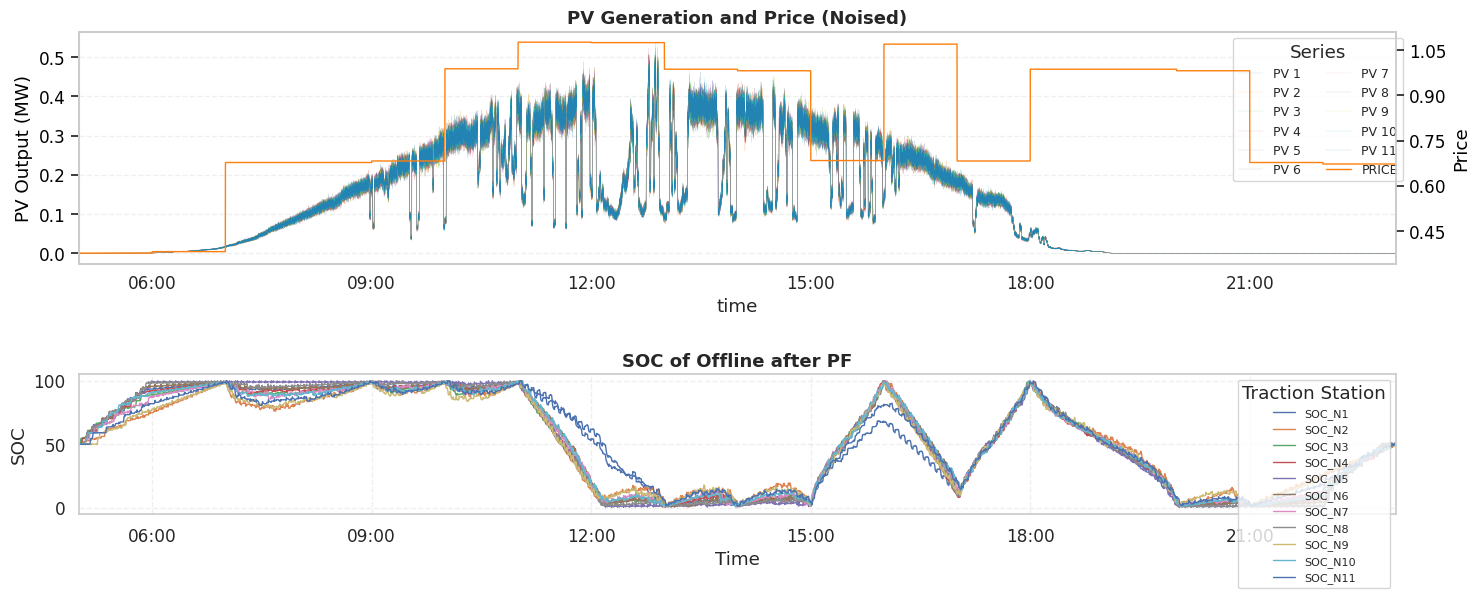

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator

# 设置 Seaborn 风格
sns.set_theme(style="whitegrid", font_scale=1.1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6), gridspec_kw={'height_ratios':[1, 0.6]})

# -------------------------
# 上图：PV + PRICE
# -------------------------
pv_cols = [int(i) for i in range(1, 12)]
pv_colors = sns.color_palette("tab10", n_colors=len(pv_cols))

for i, col in enumerate(pv_cols):
    PV_Price_Noised[str(col)].plot(ax=ax1, color=pv_colors[i], linewidth=0.1, alpha=0.8, label=f'PV {col}')

ax2_price = ax1.twinx()
PV_Price_Noised['PRICE'].plot(ax=ax2_price, color='tab:orange', linewidth=1, label='PRICE')

# 美化
ax1.set_ylabel("PV Output (MW)", color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax2_price.set_ylabel("Price", color='black')
ax2_price.tick_params(axis='y', labelcolor='black')
ax1.yaxis.set_major_locator(MaxNLocator(nbins=6))
ax2_price.yaxis.set_major_locator(MaxNLocator(nbins=6))

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2_price.get_legend_handles_labels()
ax1.legend(lines1 + lines2
           , labels1 + labels2
           , loc='upper right'
           , bbox_to_anchor=(1.01, 1.0)
           , ncol=2
           , fontsize=9
           , title="Series")

ax1.set_title("PV Generation and Price (Noised)", fontsize=13, weight='bold')
ax1.grid(True, linestyle='--', alpha=0.3)
ax2_price.grid(False)

# -------------------------
# 下图：SOC
# -------------------------
SOCs.plot(ax=ax2, linewidth=1)
ax2.set_title("SOC of Offline after PF", fontsize=13, weight='bold')
ax2.set_ylabel("SOC")
ax2.set_xlabel("Time")
ax2.grid(True, linestyle='--', alpha=0.3)
ax2.legend(title="Traction Station", loc='upper right', fontsize=8)

# -------------------------
# 固定 x 轴时间刻度（手动指定）
# -------------------------
# 根据 PV_Price_Noised 的日期生成统一的时间标签
date_str = PV_Price_Noised.index[0].strftime("%Y-%m-%d")
time_ticks = pd.to_datetime([f"{date_str} 06:00:00",
                             f"{date_str} 09:00:00",
                             f"{date_str} 12:00:00",
                             f"{date_str} 15:00:00",
                             f"{date_str} 18:00:00",
                             f"{date_str} 21:00:00"])

# SOC 图 x 轴：用插值或最接近的 index 找到对应位置
# 这里简单做 nearest match
tick_positions = [SOCs.index.get_loc(SOCs.index[SOCs.index.get_indexer([t], method='nearest')[0]]) 
                  for t in time_ticks]
ax2.set_xticks([SOCs.index[pos] for pos in tick_positions])
ax2.set_xticklabels([t.strftime("%H:%M") for t in time_ticks])

plt.tight_layout(h_pad=2)
fig.savefig('/home/gzt/Codes/2STAGE/paper_pic/PV_SOC_combined_test.pdf', format='pdf')
plt.show()


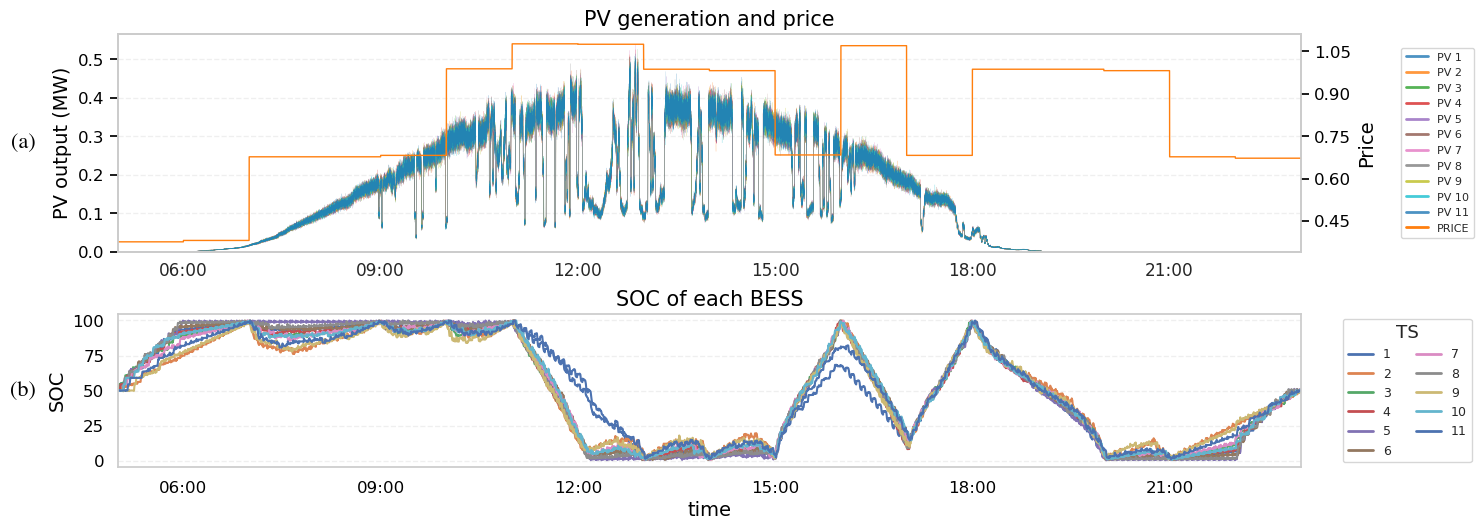

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
from matplotlib import font_manager

# -------------------------
# 指定 Times 字体，用于 (a)/(b) 子图标记
# -------------------------
font_path = "/home/gzt/.local/share/fonts/times/Times.ttc"
time_font = font_manager.FontProperties(fname=font_path)

sns.set_theme(style="whitegrid", font_scale=1.1)

# 增加 ax1 的高度比例
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 5.5),
                               gridspec_kw={'height_ratios': [0.85, 0.6]})

# 统一颜色和字体设置
label_fontsize = 14
tick_fontsize = 12
axis_color = 'black'
tick_color = 'black'

# -------------------------
# 上图：PV + PRICE
# -------------------------
pv_cols = [int(i) for i in range(1, 12)]
pv_colors = sns.color_palette("tab10", n_colors=len(pv_cols))

for i, col in enumerate(pv_cols):
    PV_Price_Noised[str(col)].plot(ax=ax1, color=pv_colors[i],
                                   linewidth=0.1, alpha=0.8, label=f'PV {col}')

ax2_price = ax1.twinx()
PV_Price_Noised['PRICE'].plot(ax=ax2_price, color='tab:orange',
                              linewidth=1, label='PRICE')

# 统一设置颜色和字体
ax1.set_ylabel("PV output (MW)", fontsize=label_fontsize, color=axis_color)
ax1.tick_params(axis='y', labelsize=tick_fontsize, labelcolor=tick_color, color=axis_color)
ax1.tick_params(axis='x', labelsize=tick_fontsize, labelcolor=tick_color, color=axis_color)
ax1.yaxis.label.set_color(axis_color)

# 设置 ax1 的 y 轴从 0 开始
ax1.set_ylim(bottom=0)

# 隐藏 ax1 的 x 轴刻度和标签
ax1.set_xticks([])  # 清除 x 轴刻度
ax1.set_xlabel('')  # 清除 x 轴标签

ax2_price.set_ylabel("Price", fontsize=label_fontsize, color=axis_color)
ax2_price.tick_params(axis='y', labelsize=tick_fontsize, labelcolor=tick_color, color=axis_color)
ax2_price.yaxis.label.set_color(axis_color)

ax1.yaxis.set_major_locator(MaxNLocator(nbins=6))
ax2_price.yaxis.set_major_locator(MaxNLocator(nbins=6))

# 双轴图 legend - 调整位置向右移动，缩短高度
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2_price.get_legend_handles_labels()
leg1 = ax1.legend(lines1 + lines2,
                  labels1 + labels2,
                  loc='center left',
                  bbox_to_anchor=(1.08, 0.5),
                  ncol=1,
                  fontsize=8)

for legline in leg1.get_lines():
    legline.set_linewidth(2.0)

ax1.set_title("PV generation and price", fontsize=15, weight='normal', color='black')
ax1.grid(True, linestyle='--', alpha=0.3)
ax2_price.grid(False)

# 上图左侧中央加 "(a)"，Times 字体
ax1.text(-0.08, 0.5, '(a)', transform=ax1.transAxes,
         fontsize=16, fontproperties=time_font,
         va='center', ha='center', color='black')

# -------------------------
# 下图：SOC
# -------------------------
lines = SOCs.plot(ax=ax2, linewidth=1.5)

ax2.set_title("SOC of each BESS", fontsize=15, weight='normal', color='black')
ax2.set_ylabel("SOC", fontsize=label_fontsize, color=axis_color)
ax2.set_xlabel("time", fontsize=label_fontsize, color=axis_color)
ax2.tick_params(axis='y', labelsize=tick_fontsize, labelcolor=tick_color, color=axis_color)
ax2.tick_params(axis='x', labelsize=tick_fontsize, labelcolor=tick_color, color=axis_color)
ax2.yaxis.label.set_color(axis_color)
ax2.xaxis.label.set_color(axis_color)

# 设置 y 轴特定的网格线 (0, 25, 50, 75, 100)
ax2.set_yticks([0, 25, 50, 75, 100], minor=False)  # 设置主要刻度
ax2.grid(True, which='major', axis='y', linestyle='--', alpha=0.3)  # 只显示 y 轴网格线
ax2.grid(False, which='major', axis='x')  # 隐藏 x 轴网格线

# 下图 legend - 修改标签只保留数字，与 ax1 图例右对齐
lines_soc, labels_soc = ax2.get_legend_handles_labels()
# 只保留 SOC_N 后面的数字
new_labels = [label.split('_N')[1] if '_N' in label else label for label in labels_soc]

# 调整图例参数使其更长一些，保持两列
leg2 = ax2.legend(lines_soc, new_labels,
                  title="TS",
                  loc='center left',
                  bbox_to_anchor=(1.03, 0.5),
                  ncol=2,
                  fontsize=9)

for legline in leg2.get_lines():
    legline.set_linewidth(2.0)

# 下图左侧中央加 "(b)"，Times 字体
ax2.text(-0.08, 0.5, '(b)', transform=ax2.transAxes,
         fontsize=16, fontproperties=time_font,
         va='center', ha='center', color='black')

# -------------------------
# 固定 x 轴时间刻度
# -------------------------
# date_str = PV_Price_Noised.index[0].strftime("%Y-%m-%d")
time_ticks = pd.to_datetime([f"{date_str} 06:00:00",
                             f"{date_str} 09:00:00",
                             f"{date_str} 12:00:00",
                             f"{date_str} 15:00:00",
                             f"{date_str} 18:00:00",
                             f"{date_str} 21:00:00"])

tick_positions = [SOCs.index.get_loc(SOCs.index[SOCs.index.get_indexer([t], method='nearest')[0]])
                  for t in time_ticks]
ax2.set_xticks([SOCs.index[pos] for pos in tick_positions])
ax2.set_xticklabels([t.strftime("%H:%M") for t in time_ticks])

# 减小子图间距
plt.tight_layout(h_pad=0.5)
fig.savefig('/home/gzt/Codes/2STAGE/paper_pic/PV_SOC_combined_test.pdf',
            format='pdf', bbox_inches='tight')
plt.show()

### df_time

In [12]:
online_data_sec1["df_time"] = online_data_sec1["df_time"].astype(float)

has_nonlinear = online_data_sec1["df_time"][~online_data_sec1["df_time"]['nonlinearSolve_time'].isna()]
only_linear = online_data_sec1["df_time"][online_data_sec1["df_time"]['nonlinearSolve_time'].isna()]

has_nonlinear["sum"] = has_nonlinear.sum(axis=1)

In [13]:
has_nonlinear.describe()

,linearModel_time,linearSolve_time,linearSum_time,nonlinearModel_time,nonlinearSolve_time,sum
count,64333.000000,64333.000000,64333.000000,64333.000000,64333.000000,64333.000000
mean,0.098111,0.073822,0.171933,0.080469,0.354653,0.778988
std,0.007170,0.007404,0.010676,0.005918,0.033836,0.052506
min,0.007442,0.014641,0.022084,0.005918,0.065369,0.115453
25%,0.094818,0.068516,0.165189,0.077174,0.338052,0.750520
50%,0.098332,0.073348,0.171097,0.081038,0.354191,0.778103
75%,0.100119,0.078543,0.177693,0.082545,0.371271,0.806403
max,0.276856,0.122631,0.359908,0.159219,0.689228,1.183554


In [14]:
online_data_sec1["df_time"]["sum"] = online_data_sec1["df_time"].astype(float).sum(axis = 1)

In [15]:
online_data_sec1["df_time"].astype(float).drop(columns = ["sum"], inplace = True)

In [16]:
online_data_sec1["df_time"]["sum"] = online_data_sec1["df_time"].astype(float).sum(axis = 1)

In [17]:
online_data_sec1["df_time"]["sum"].mean()

np.float64(1.5770305373124134)

In [18]:
# 只计算出了 linear 近似解
only_linear.describe()

,linearModel_time,linearSolve_time,linearSum_time,nonlinearModel_time,nonlinearSolve_time
count,467.000000,467.000000,467.000000,0.000000,0.000000
mean,0.981476,0.068982,1.050458,NaN,NaN
std,1.902559,0.010344,1.905919,NaN,NaN
min,0.070618,0.049908,0.126154,NaN,NaN
25%,0.087950,0.060346,0.153056,NaN,NaN
50%,0.097541,0.069926,0.166639,NaN,NaN
75%,0.106255,0.076893,0.182080,NaN,NaN
max,10.156912,0.098270,10.229952,NaN,NaN


In [19]:
# linear 就超过了 1 s 的 很少
(only_linear["linearSum_time"]>1).sum()

np.int64(103)

In [20]:
# solve 超时
(has_nonlinear['sum']>1).sum()

np.int64(98)

### negative power flow

In [41]:
PF_online_data_sec1["p_ins"] = PF_online_data_sec1["p_ins"].astype(float)

print("整体表现")
display(PF_online_data_sec1["p_ins"].describe())

print("负向潮流")
tol = 1e-6
print("出现反向潮流的时刻", PF_online_data_sec1["p_ins"][PF_online_data_sec1["p_ins"]<-tol].count())

print("最大反向潮流:", PF_online_data_sec1["p_ins"][PF_online_data_sec1["p_ins"]<-tol].min().min())

print("平均反向潮流:", PF_online_data_sec1["p_ins"][PF_online_data_sec1["p_ins"]<-tol].mean())

整体表现


,1,2,3,4,5,6,7,8,9,10,11
count,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000
mean,0.529995,0.724084,0.714338,0.677238,0.682404,0.640170,0.687511,0.740203,0.755303,0.634727,0.450832
std,0.999034,0.997463,0.922255,0.853815,0.904782,0.878272,0.936429,0.995373,1.024582,0.937523,0.826953
min,-0.000232,-0.000742,-0.000573,-0.000932,-0.001063,-0.000865,-0.001811,-0.001319,-0.001141,-0.001854,-0.000940
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.379877,0.468218,0.409101,0.408418,0.320819,0.308921,0.295676,0.336852,0.268663,0.068820
75%,0.635990,0.983342,1.030347,1.033194,0.973914,0.964058,0.979218,1.165167,1.100493,0.777668,0.578647
max,7.375873,6.385546,6.388038,6.526789,6.418519,5.680392,5.748812,7.526224,7.180752,5.924295,7.099846


负向潮流
出现反向潮流的时刻 1     13
2     13
3      9
4     11
5      4
6      5
7      9
8      9
9     12
10    11
11    16
dtype: int64
最大反向潮流: -0.0018539205548506
平均反向潮流: 1    -0.000117
2    -0.000392
3    -0.000426
4    -0.000540
5    -0.000501
6    -0.000389
7    -0.000429
8    -0.000723
9    -0.000794
10   -0.000586
11   -0.000316
dtype: float64


In [45]:
(PF_online_data_sec1["p_ins"][PF_online_data_sec1["p_ins"]<0].count()).sum()

np.int64(163)

In [46]:
163/(18*60*60)

0.002515432098765432

### p_ch & p_disch

In [40]:
PF_online_data_sec1["p_chs"] = PF_online_data_sec1["p_chs"].astype(float)
PF_online_data_sec1["p_dischs"] = PF_online_data_sec1["p_dischs"].astype(float)
tol = 1 # MW

print("同时充放电个数")
display(((PF_online_data_sec1["p_chs"]>tol) & (PF_online_data_sec1["p_dischs"]<-tol)).sum())

print("L1正则项")
display((PF_online_data_sec1["p_chs"] - PF_online_data_sec1["p_dischs"]).describe())

print("同时充放电的 L1正则项")
display((PF_online_data_sec1["p_chs"] - PF_online_data_sec1["p_dischs"])[(PF_online_data_sec1["p_chs"]>tol) & (PF_online_data_sec1["p_dischs"]<-tol)].describe())



同时充放电个数


index      0
1         16
2          0
3          0
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11       573
dtype: int64

L1正则项


,index,1,2,3,4,5,6,7,8,9,10,11
count,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000,64800.000000
mean,0.000000,0.383301,0.668198,0.424632,0.458948,0.554260,0.677216,0.640501,0.521932,0.563577,0.592419,0.481535
std,0.000000,0.721086,0.957608,0.819991,0.846949,0.939049,1.023757,0.996214,0.931420,0.912282,0.956747,0.893264
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.081343,0.141486,0.000000,0.000000,0.000000,0.067840,0.023515,0.000741,0.042536,0.022108,0.087048
75%,0.000000,0.368101,0.895664,0.441128,0.539431,0.734916,0.979121,0.865576,0.547220,0.744676,0.784930,0.550891
max,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,5.806651


同时充放电的 L1正则项


,index,1,2,3,4,5,6,7,8,9,10,11
count,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,573.000000
mean,NaN,2.548955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.095632
std,NaN,0.169756,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.732706
min,NaN,2.338652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.136058
25%,NaN,2.421106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.671242
50%,NaN,2.543374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.346606
75%,NaN,2.601502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.569384
max,NaN,2.928729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.806651


In [38]:
1205/(18*60*60)

0.01859567901234568

In [37]:
((PF_online_data_sec1["p_chs"]>tol) & (PF_online_data_sec1["p_dischs"]<-tol)).sum().sum()

np.int64(1205)

### cost

In [23]:
# ---------- Cost Compute
def cost_compute_split(p_ins, delta_t, length):
    pIn_NoNeg = p_ins.astype('float').reset_index(drop=True).clip(lower = 0).iloc[:length]
    df_cost = delta_t * (pIn_NoNeg.mul(PV_Price_Noised['PRICE'].reset_index(drop=True).iloc[:length].values, axis=0))
    return df_cost

cost_horizon = min(len(PF_offline_org['p_ins']), len(PF_online_data_sec1['p_ins']))
cost_offline = cost_compute_split(PF_offline_org['p_ins'], delta_t=1, length=cost_horizon)
cost_online = cost_compute_split(PF_online_data_sec1['p_ins'], delta_t=1, length=cost_horizon) 

In [24]:
PF_offline_org['p_ins']

,1,2,3,4,5,6,7,8,9,10,11
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.308040,0.072804,0.014683,0.004167,0.001031,0.000611,0.001296,0.004944,0.019190,0.085942,0.289172
3,0.308040,0.072804,0.014683,0.004167,0.001031,0.000611,0.001296,0.004944,0.019190,0.085942,0.289172
4,0.308040,0.072804,0.014683,0.004167,0.001031,0.000611,0.001296,0.004944,0.019190,0.085942,0.289172
...,...,...,...,...,...,...,...,...,...,...,...
64795,0.432250,0.295498,0.220917,0.473936,1.064491,0.621892,0.878224,0.513131,0.482547,0.543049,0.355232
64796,0.434766,0.304326,0.212467,0.475618,1.062019,0.626424,0.877973,0.513055,0.482477,0.542797,0.362570
64797,0.437320,0.313289,0.204592,0.477464,1.059578,0.630971,0.877732,0.512982,0.482409,0.542555,0.369918
64798,0.439911,0.322388,0.197296,0.479474,1.057168,0.635533,0.877499,0.512911,0.482343,0.542325,0.377276


In [25]:
PF_online_data_sec1["p_ins"].sum().sum() / PF_offline_org['p_ins'].sum().sum()

np.float64(1.197628653540147)

In [26]:
print(f"online cost 是 offline cost 的 {(cost_online.sum().sum() / cost_offline.sum().sum())} 倍")

online cost 是 offline cost 的 1.1619078982331688 倍


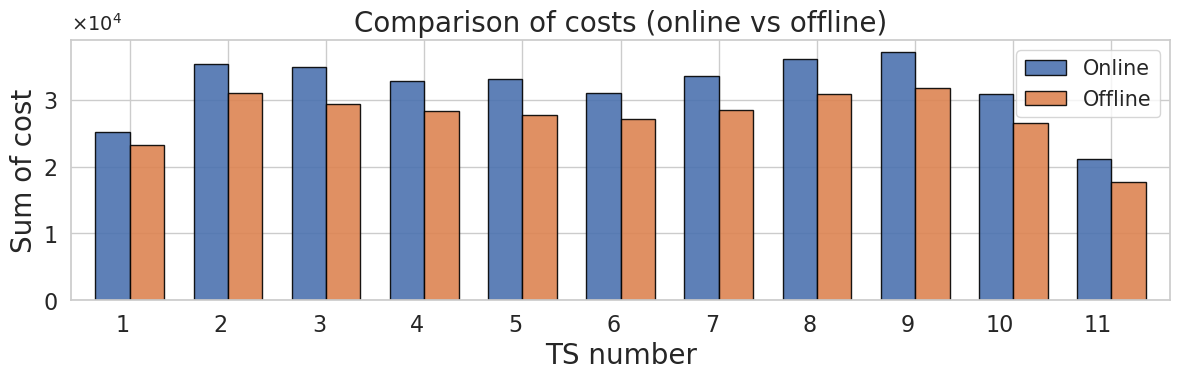

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import font_manager

# 假设你的两个 DataFrame 已经存在
online_sum = cost_online.sum()
offline_sum = cost_offline.sum()

# 拼成一个新的 DataFrame
df_compare = pd.DataFrame({
    'Online': online_sum,
    'Offline': offline_sum
})

# 绘制并列柱状图（y 值除以 1e4）
ax = (df_compare / 1e4).plot(
    kind='bar',
    figsize=(12, 4),
    width=0.7,
    alpha=0.9,
    edgecolor='black'
)

# 美化图形（使用默认字体）
ax.set_title("Comparison of costs (online vs offline)", fontsize=20)
ax.set_ylabel("Sum of cost", fontsize=20)
ax.set_xlabel("TS number", fontsize=20)

# 增大刻度标签字体
ax.tick_params(axis='both', which='major', labelsize=16)

# 在 y 轴左上角额外加上 1e4（使用默认字体）
ax.text(
    0.0, 1.02, r'$\times 10^4$', 
    transform=ax.transAxes, 
    fontsize=14, 
    va='bottom', ha='left'
)

# 图例（使用默认字体，增大字体）
plt.legend(fontsize=15, title_fontsize=15)

plt.xticks(rotation=0, ha='right')
plt.tight_layout()

# 保存为矢量图 (pdf/svg)
plt.savefig(f"/home/gzt/Codes/2STAGE/paper_pic/cost_comparison_{log}.pdf", format="pdf")
# plt.savefig("/home/gzt/Codes/2STAGE/paper_pic/cost_comparison.svg", format="svg")
plt.show()

In [64]:
online_data_sec1["SOCs"].min()

index           H0
SOC_N1    0.964742
SOC_N2    1.119491
SOC_N3    0.965800
SOC_N4    0.851745
SOC_N5    0.262107
SOC_N6    0.405636
SOC_N7    0.497062
SOC_N8    0.652649
SOC_N9    1.113683
SOC_N10   0.555103
SOC_N11   1.130046
dtype: object

In [63]:
online_data_sec1["SOCs"].max()

index          H9999
SOC_N1    100.000000
SOC_N2    100.000000
SOC_N3     99.331224
SOC_N4     99.812089
SOC_N5    100.000000
SOC_N6    100.000000
SOC_N7    100.000000
SOC_N8    100.000000
SOC_N9    100.000000
SOC_N10   100.000000
SOC_N11   100.000000
dtype: object

### fix time

In [28]:
#!/usr/bin/env python
# -*- encoding: utf-8 -*-
'''
@File    :   power_flow_org.py
@Time    :   2025/02/20 20:26:54
@Author  :   勾子瑭
'''

# here put the import lib
import time
import re
import numpy as np
import gurobipy as gp
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

def power_flow_org(power_flow_start, power_flow_horizon, DFs, DFs_noStop, PV_Price, Ys, params,  in_PV = False, use_brake=False):
    ### simulation
    current_t = power_flow_start
    horizon = power_flow_horizon
    current_t += 0

    # DF and Y computing time
    time_DF_read = time.time() # DF and Y computing time

    # horizon list 
    dfs = DFs[current_t:current_t+horizon]
    # dfs_pv = PV_Price.loc[current_t:current_t+horizon-1, 'PV'].values # convert to unit MW
    dfs_noStop = DFs_noStop[current_t:current_t+horizon]
    ys = Ys[current_t:current_t+horizon]
    PV_Price = PV_Price.iloc[current_t:current_t+horizon,:]
    pv = PV_Price.drop(columns=["PRICE"])
    price = PV_Price["PRICE"]

    ####### GUROBI #######
    nums_noStop = np.zeros(shape=horizon,dtype='int64')
    nums_Tss = dfs[0]['class'].sum()

    # var [[[] for i in range(nums_noStop[t])] for t in range(horizon)]
    v = {}
    p_in = {}

    PF_vs_org = pd.DataFrame(columns=['Volt_N{}'.format(i) for i in range(1,nums_Tss+1)])
    PF_p_ins = pd.DataFrame(columns=['P_from_Source_N{}'.format(i) for i in range(1,nums_Tss+1)])

    P = {}
    for t in range(horizon):
        nums_noStop[t] = len(dfs_noStop[t].index.values)
        P[t] = dfs_noStop[t]['P'].values # convert to unit MW

    for t in range(horizon):
        clear_output(wait=True)
        print(f'开始进行第 {t} 个时刻的潮流求解')

        # model
        model = gp.Model()
        # var [[[] for i in range(nums_noStop[t])] for t in range(horizon)]
        v = {}
        p_in = {}
        p_g = {}
        p_brake = {}

        q_expr = gp.QuadExpr()
        l_expr = gp.LinExpr()

        # variables
        for i in dfs_noStop[t].index:
            if dfs_noStop[t].loc[i,'class']==1:
                v[t,i] = model.addVar(lb=0, ub=2, name='Volt_N{}_H{}'.format(str(dfs_noStop[t].loc[i,'name']),t))
                p_in[t,i] = model.addVar(lb=-10, ub=10, vtype=gp.GRB.CONTINUOUS, name='P_from_Source_N{}_H{}'.format(dfs_noStop[t].loc[i,'name'],t))
            elif dfs_noStop[t].loc[i,'class']==0:
                v[t,i] = model.addVar(lb=0, ub=2, name='Volt_N{}_H{}'.format(str(dfs_noStop[t].loc[i,'name']),t))
                if use_brake:
                    p_brake[t,i] = model.addVar(lb=params.p_brake_min, ub=params.p_brake_max, vtype=gp.GRB.CONTINUOUS,name='P_brake_N{}_H{}'.format(dfs_noStop[t].loc[i,'name'],t))
                pass

        # constraints
        for i in dfs_noStop[t].index:

            if dfs_noStop[t].loc[i,'class'] == 1:
                # ### p_in
                l_expr = gp.LinExpr()
                l_expr.addTerms(params.Rs,p_in[t,i])
                l_expr.addTerms(params.E,v[t,i])
                model.addConstr(l_expr == params.E*params.E, name='P_IN_N{}_H{}'.format(i,t))
                l_expr.clear()
                
                ### power flow of station
                #### q_expr = YVV - V_i^2/params.Rs 
                q_expr.addTerms(-1/params.Rs,v[t,i],v[t,i])
                for j in range(nums_noStop[t]):
                    # print(t,i,j)
                    q_expr.addTerms(ys[t][i,j],v[t,i],v[t,j])

                p_sum = 0 # PV 算重复了
                if dfs_noStop[t].loc[i,'upStop'] > 0:
                    p_sum -= dfs[t].loc[dfs[t]['name']==dfs_noStop[t].loc[i,'upStop'],'P'].values[0]
                if dfs_noStop[t].loc[i,'downStop'] > 0 and dfs_noStop[t].loc[i,'downStop'] != dfs_noStop[t].loc[i,'upStop']:
                    p_sum -= dfs[t].loc[dfs[t]['name']==dfs_noStop[t].loc[i,'downStop'],'P'].values[0]
                if in_PV:
                    p_sum += pv.iloc[t,i]
                l_expr.addTerms(params.E/params.Rs,v[t,i])
                # print(p_sum)
                l_expr.addConstant(p_sum)

                model.addQConstr(-q_expr == l_expr, name='PF_N{}_H{}'.format(dfs_noStop[t].loc[i,'name'],t))
                q_expr.clear()
                l_expr.clear()


            elif dfs_noStop[t].loc[i,'class'] == 0:
                # ### train braking power balance
                # train_name = int(dfs_noStop[t].loc[i,'name'])
                # model.addConstr(p_brake[t,i] == p_brakes.loc[t,train_name], name = "train brake input_N{}_{}".format(dfs_noStop[t].loc[i,'name'],t))
                # # print(f"p_brake == {p_brakes.loc[t,train_name]}")


                ### power flow of train
                for j in range(nums_noStop[t]):
                    q_expr.addTerms(ys[t][i,j],v[t,i],v[t,j])
                if use_brake:
                    model.addQConstr(q_expr  == P[t][i] + p_brake[t,i], name='PF_N{}_H{}'.format(dfs_noStop[t].loc[i,'name'],t))
                else:
                    model.addQConstr(q_expr  == P[t][i], name='PF_N{}_H{}'.format(dfs_noStop[t].loc[i,'name'],t))

                q_expr.clear()
                l_expr.clear()



        # objective function
        model.setObjective(1, sense=gp.GRB.MINIMIZE)

        model.setParam('OutputFlag',0)
        model.setParam('NonConvex',2)
        model.setParam('PreSolve',1)
        model.setParam('NumericFocus',0)
        model.setParam('FeasibilityTol',1e-9)
        model.params.MIPGap = 0.001
        time_model = time.time()
        # model.write('/Users/town/Desktop/STU/Code/Jupyter_Code/Master/Main/2Stage/GrbLog/PF_log/PF_org.LP')
        # model.write('/Users/town/Desktop/STU/Code/Jupyter_Code/Master/Main/2Stage/GrbLog/PF_log/PF_org.MPS')

        model.optimize()
        time_slove = time.time()
        # model.write('/Users/town/Desktop/STU/Code/Jupyter_Code/Master/Main/2Stage/GrbLog/PF_log/PF_org.SOL')

        # 获取求解信息
        print('the objective value is : {}'.format(model.ObjVal))
        for x in model.getVars():
            if 'Volt' in x.VarName:
                match = re.match(r'Volt_N(\d+)_H(\d+)',x.VarName)
                PF_vs_org.loc[int(match.group(2)),'Volt_N'+match.group(1)] = x.X
                # PF_vs_org.append(x.X)
            elif 'P_from_Source' in x.VarName:
                match = re.match(r'P_from_Source_N(\d+)_H(\d+)',x.VarName)
                PF_p_ins.loc[int(match.group(2)),'P_from_Source_N'+match.group(1)] = x.X
                # PF_p_ins.append(x.X)
            else:
                print('遗漏了变量')

    # stopping train voltage recover
    for col in PF_vs_org.columns[11:]:
        match = re.match('Volt_N(\d+)',col)
        num_train = int(match.group(1))
        for idx in PF_vs_org[col].index:
            if pd.isna(PF_vs_org.loc[idx,col]):
                match = re.match('H(\d+)',idx)
                num_horizon = int(match.group(1))
                current_DF = DFs[num_horizon]
                if num_train in current_DF['name'].values:
                    stoppingTss = current_DF.loc[current_DF['name']==num_train,'stopping'].values[0]
                    if stoppingTss > 0 :
                        # print(stoppingTss)
                        PF_vs_org.loc[idx,col] = PF_vs_org.loc[idx,'Volt_N'+str(stoppingTss)]
            else: pass
        # time_list = [ time_df_read-time_DF_read
        #             , time_model-time_df_read
        #             , time_slove-time_model]
        # print('建模耗时: {} s\n求解耗时: {} s\n'.format(time_list[1],time_list[2]))

    PF_data = {'vs':PF_vs_org.astype('float')
               ,'p_ins':PF_p_ins.astype('float')}
    return PF_data

In [ ]:
PF_data = power_flow_org(power_flow_start=0
                        , power_flow_horizon=prcs.params.offline_horizon
                        , DFs=prcs.DFs
                        , DFs_noStop=prcs.DFs_noStop
                        , PV_Price=PV_Price_Noised
                        , Ys=prcs.Ys
                        , params=prcs.params
                        ,  in_PV = True)

In [31]:
PF_data['vs']

NameError: name 'PF_data' is not defined

In [47]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
from matplotlib import font_manager

def plot_combined_save(df_nodes, DFs, h, vs1, vs2, num_tss, save_path):
    """
    绘制列车拓扑和电压对比图，字体稍微小一点，避免元素重叠，左侧y轴加粗。
    """
    fig = plt.figure(figsize=(16, 7))
    gs = GridSpec(3, 1, height_ratios=[0.8, 1.0, 1.0], hspace=0.35, figure=fig)

    # -------------------------
    # 指定 Times 字体，用于 (a)/(b) 子图标记
    # -------------------------
    font_path = "/home/gzt/.local/share/fonts/times/Times.ttc"
    time_font = font_manager.FontProperties(fname=font_path)

    # 字体大小
    TITLE_FS = 14
    LABEL_FS = 12
    TICK_FS = 10
    LEGEND_FS = 10
    NODE_FS = 8

    # ------------------- 上图：列车拓扑 -------------------
    ax0 = fig.add_subplot(gs[0])
    y_up, y_tss, y_down = 2.6, 2.0, 1.4
    # 增加偏移量，让机车编号与机车标记距离更远
    y_offset = 0.14

    colors_status = {-5: '#007F5F', 5: '#D62728', 1.5: '#FF7F0E', 0.4: '#1F77B4'}
    tss_color, tss_marker = 'royalblue', 's'
    # 放大列车标记尺寸
    markers_train = {'up': '>', 'down': '<'}

    tss_nodes = df_nodes[df_nodes['class'] == 1]
    tss_locations_km = DFs[h].loc[tss_nodes.index, 'location'].values / 1000
    tss_names = [f"TSS{idx+1}" for idx in tss_nodes.index]

    min_location = tss_locations_km.min() - 0.2
    max_location = tss_locations_km.max() + 0.2
    ax0.set_xlim(min_location, max_location)
    ax0.set_ylim(y_down - 0.5, y_up + 0.5)
    ax0.set_facecolor('#f9f9f9')
    ax0.hlines([y_up, y_down], xmin=min_location, xmax=max_location, colors='gray', linestyles='--', linewidth=0.8, alpha=0.6)

    for _, row in df_nodes.iterrows():
        x_km = DFs[h].loc[row.name, 'location'] / 1000
        if row['class'] == 1:
            ax0.scatter(x_km, y_tss, color=tss_color, marker=tss_marker, s=100, edgecolor='black', zorder=5)
            ax0.scatter(x_km, y_up, color=tss_color, marker='|', s=40, zorder=4)
            ax0.scatter(x_km, y_down, color=tss_color, marker='|', s=40, zorder=4)
        else:
            y_pos = y_up if (row['upPre'] != 0 or row['upPost'] != 0) else y_down
            marker = markers_train['up'] if y_pos==y_up else markers_train['down']
            # 所有列车编号都放在下面，增加距离
            text_y = y_pos - y_offset

            P_val = DFs[h].loc[row.name, 'P']
            if P_val <= -5: c = colors_status[-5]
            elif P_val >= 5: c = colors_status[5]
            elif P_val == 1.5: c = colors_status[1.5]
            elif P_val == 0.4: c = colors_status[0.4]
            else: c = 'gray'

            # 放大列车标记尺寸
            ax0.scatter(x_km, y_pos, color=c, marker=marker, s=100, edgecolor='black', zorder=5)
            ax0.text(x_km, text_y, f"{row.name+1}", ha='center', va='top', fontsize=NODE_FS, color='black', zorder=6)

    legend_elements = [
        plt.Line2D([0], [0], marker=tss_marker, color='w', label='TSS', markerfacecolor=tss_color, markersize=12, markeredgecolor='black'),
        plt.Line2D([0], [0], marker=markers_train['up'], color='w', label='Up Train', markerfacecolor='gray', markersize=12, markeredgecolor='black'),  # 放大尺寸
        plt.Line2D([0], [0], marker=markers_train['down'], color='w', label='Down Train', markerfacecolor='gray', markersize=12, markeredgecolor='black'),  # 放大尺寸
        plt.Line2D([0], [0], marker='o', color='w', label='Braking', markerfacecolor=colors_status[-5], markersize=8, markeredgecolor='black'),
        plt.Line2D([0], [0], marker='o', color='w', label='Starting', markerfacecolor=colors_status[5], markersize=8, markeredgecolor='black'),
        plt.Line2D([0], [0], marker='o', color='w', label='Constant', markerfacecolor=colors_status[1.5], markersize=8, markeredgecolor='black'),
        plt.Line2D([0], [0], marker='o', color='w', label='Coasting', markerfacecolor=colors_status[0.4], markersize=8, markeredgecolor='black')
    ]
    ax0.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=7, frameon=True, framealpha=0.9, fontsize=LEGEND_FS)

    # x轴刻度往下移动，避免与子图重叠
    for loc, name in zip(tss_locations_km, tss_names):
        ax0.text(loc, y_down - 0.55, f"{name}\n{loc:.1f} km", ha='center', va='top', fontsize=NODE_FS)

    # 左侧 y 轴加粗
    ax0.set_yticks([y_down, y_tss, y_up])
    ax0.set_yticklabels(['Down', 'TSS', 'Up'], fontsize=LABEL_FS, fontweight='normal')

    ax0.grid(True, linestyle=':', alpha=0.4)
    ax0.set_title("Railway topology", fontsize=TITLE_FS, weight='normal', loc="left")
    ax0.set_xticks([])

    # 添加 (a) 标记
    ax0.text(-0.08, 0.5, '(a)', transform=ax0.transAxes,
             fontsize=16, fontproperties=time_font,
             va='center', ha='center')

    # ------------------- 电压对比 -------------------
    def draw_voltage(axs, vs1, vs2, DFs, h):
        def process_vs(vs, h, DFs):
            vs_p = vs.copy()
            df = DFs[h].copy()
            vs_p.columns = vs_p.columns.map(lambda x: x.split('_N')[1])
            vs_p.columns = vs_p.columns.astype(int)
            cut_vs = vs_p.iloc[h]
            cut_vs.name = "vs"
            df["name"] = df["name"].astype(int)
            df.set_index("name", inplace=True)
            df = df.join(cut_vs)
            df = df.sort_values("location").reset_index()
            for i in df.index:
                df.loc[i, "name"] = "TSS"+str(df.loc[i,"name"]) if df.loc[i,"class"]==1 else "Train"+str(df.loc[i,"name"])
            return df

        df1 = process_vs(vs1, h, DFs)
        df2 = process_vs(vs2, h, DFs)
        y_range = (min(df1["vs"].min(), df2["vs"].min())-0.01, max(df1["vs"].max(), df2["vs"].max())+0.01)

        for idx, (ax, df, title) in enumerate(zip(axs, [df1, df2], ['Voltage of nodes (no exploitation of BESS)', 'Voltage of nodes (our algorithm)'])):
            x = range(len(df))
            ax.plot(x, df["vs"], color="black", linewidth=1.2)
            tss_mask = (df["class"]==1)&(df["vs"].between(y_range[0], y_range[1]))
            ax.scatter([i for i in x if tss_mask[i]], df.loc[tss_mask,"vs"], marker='s', s=80, color='blue', label="TSS")
            train_mask = (df["class"]==0)&(df["vs"].between(y_range[0], y_range[1]))
            ax.scatter([i for i in x if train_mask[i]], df.loc[train_mask,"vs"], marker='o', s=60, color='gray', label="Train")
            # 修复x轴范围，增加边距确保右边刻度显示
            ax.set_xlim([-1, len(df)])
            ax.set_ylim(y_range)
            ax.axhline(y=1.593, color=(0.79,0,0.09), linestyle='--')
            ax.set_ylabel('Voltage (kV)', fontsize=LABEL_FS, fontweight='normal')
            ax.set_title(title, fontsize=TITLE_FS, fontweight='normal', loc="left")
            ax.set_xticks(x)
            if idx==1:
                ax.set_xticklabels(df["name"], rotation=45, ha='right', fontsize=TICK_FS)
            else:
                ax.set_xticklabels([])
            ax.tick_params(axis='y', labelsize=TICK_FS)
            ax.grid(True, linestyle='--', alpha=0.6)
            ax.legend(loc='upper right', fontsize=LEGEND_FS)
            
            # 添加 (b) 和 (c) 标记
            if idx == 0:
                ax.text(-0.08, 0.5, '(b)', transform=ax.transAxes,
                        fontsize=16, fontproperties=time_font,
                        va='center', ha='center')
            else:
                ax.text(-0.08, 0.5, '(c)', transform=ax.transAxes,
                        fontsize=16, fontproperties=time_font,
                        va='center', ha='center')

    axs_voltage = [fig.add_subplot(gs[1]), fig.add_subplot(gs[2])]
    draw_voltage(axs_voltage, vs1, vs2, DFs, h)

    plt.tight_layout(pad=2, h_pad=0.5)
    fig.savefig(save_path, format='pdf', bbox_inches='tight')
    print(f"Saved combined figure to {save_path}")

In [ ]:
PF_data['vs']

In [48]:
# PF_data = PF_online_data_sec1
plot_combined_save(prcs.DFs[1353], prcs.DFs, 1353, PF_data["vs"], PF_online_data_sec1["vs"], 11, "/home/gzt/Codes/2STAGE/paper_pic/vs_topology_combined_test.pdf")

IndexError: list index out of range

In [34]:
prcs.DFs[1353][["name", "stopping"]]

IndexError: list index out of range

In [35]:
PF_data["vs"].iloc[1353,:]

NameError: name 'PF_data' is not defined

In [36]:
PF_data["vs"].loc[1353,"Volt_N12"] = PF_data["vs"].loc[1353,"Volt_N9"]
PF_data["vs"].loc[1353,"Volt_N14"] = PF_data["vs"].loc[1353,"Volt_N7"]
PF_data["vs"].loc[1353,"Volt_N16"] = PF_data["vs"].loc[1353,"Volt_N5"]

NameError: name 'PF_data' is not defined